In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
import os
load_dotenv()

True

In [4]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [6]:
system_prompt = """You are a helpful AI assistant.
- Use Tavily Search ONLY when the user asks about recent, factual, or web-based information.

"""
# - If the question is simple or general knowledge, answer directly without calling tools.

llm = ChatOllama(model="llama3.1:8b", 
                 temperature=0,
                 system=system_prompt)


tavily_tool = TavilySearch(
    tavily_api_key=TAVILY_API_KEY,
    max_results=3
)

tools = [tavily_tool]

llm_with_tools = llm.bind_tools(tools)

In [7]:
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.1:8b', temperature=0.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests information from specific websites (e.g., "Find climate data from nasa.gov")\n        2. The user ment

In [8]:
def chatbot_node(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # if hasattr(response, "tool_calls") and response.tool_calls:
    #     for tc in response.tool_calls:
    #         print(f"[TOOL CALL] Model requested tool: {tc['name']} with args: {tc['args']}")
    # else:
    #     print("[NO TOOL CALL] Model responded directly.")

    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot_node)

In [9]:
# Tool execution node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [10]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition) 
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [11]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

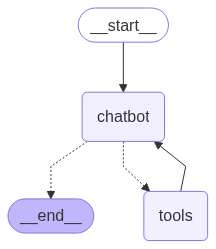

In [12]:
graph

In [13]:
def chat_loop(thread_id = "ollama_tavily_thread"):
    config = {"configurable": {"thread_id": thread_id}}

    while True:
        user_input = input("\nUser: ")
        if user_input.lower() in ("quit", "exit", "q"):
            print("Goodbye!")
            break

        events = graph.stream(
            # {"messages": [{"role": "user", "content": user_input}]},
            {
                "messages": [
                            # {"role": "system", "content": "You are a helpful AI assistant. Use Tavily to look up real-time facts. Always provide short, reliable answers."},
                            {"role": "user", "content": user_input}
                        ]
                },
            config,
            stream_mode="values"
        )

        for event in events:
            if "messages" in event:
                print("Bot:", event["messages"][-1].content)

In [14]:
chat_loop("thread_1")


Bot: what you use
Bot: 
Bot: {"query": "what you use", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://forum.juce.com/t/include-what-you-use/60420", "title": "Include-what-you-use - Useful Tools and Components - JUCE Forum", "content": "Mar 12, 2024·include-what-you-use is a nice tool making C++ more beginner friendly and have the same redundant import warnings given by modern languages", "score": 0.62330866, "raw_content": null}, {"url": "https://include-what-you-use.org/", "title": "include-what-you-use - A tool for use with clang to analyze ...", "content": "The include-what-you-use tool is a program that can be built with the clang libraries in order to analyze #includes of source files to find include-what-you-", "score": 0.5931622, "raw_content": null}, {"url": "https://stackoverflow.com/questions/45528524/include-what-you-use", "title": "c++ - \"Include What You Use\" - Stack Overflow", "content": "Aug 6, 2017·Include-What-You-Use should b

In [15]:
chat_loop("ollama_tavily_thread")


Bot: fuck
Bot: 
Bot: {"query": "fuck", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://soundcloud.com/deadddinside/sets/fuck", "title": "fuck+ - SoundCloud", "content": "Oct 26, 2020·Listen to fuck+, a playlist curated by severehate on desktop and mobile.", "score": 0.4315129, "raw_content": null}, {"url": "https://www.youtube.com/playlist?list=PLPcpcdosjx-Ghry7x2iPbdFqmRxNakAm3", "title": "fuck+ - YouTube", "content": "fuck+ · Skrillex And Diplo - Febreze (Feat. 2 Chainz) · Kendrick Lamar - A.D.H.D (Official Video) · Kendrick Lamar - i (Audio) · Bullet For My Valentine - Worthless", "score": 0.3667717, "raw_content": null}, {"url": "https://in.pinterest.com/narcisjesus666/", "title": "fuck+ (NarcisJesus666) – Profile | Pinterest", "content": "See what fuck+ (NarcisJesus666) has discovered on Pinterest, the world's biggest collection of ideas.", "score": 0.34329823, "raw_content": null}], "response_time": 1.48, "request_id": "a79b0c6e-ed57-422f-9

In [16]:
chat_loop("thread_2")

Goodbye!


In [17]:
checkpoints_3 = list(memory.list(config={"configurable": {"thread_id": "ollama_tavily_thread"}}))
checkpoints_3

[CheckpointTuple(config={'configurable': {'thread_id': 'ollama_tavily_thread', 'checkpoint_ns': '', 'checkpoint_id': '1f08434f-b573-6439-8003-4bd712b0104b'}}, checkpoint={'v': 4, 'ts': '2025-08-28T17:32:33.844741+00:00', 'id': '1f08434f-b573-6439-8003-4bd712b0104b', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.035133111440498355', 'messages': '00000000000000000000000000000005.0.8503245260403669', 'branch:to:chatbot': '00000000000000000000000000000005.0.8503245260403669', 'branch:to:tools': '00000000000000000000000000000004.0.1535336396224556'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.4292369313048049'}, 'chatbot': {'branch:to:chatbot': '00000000000000000000000000000004.0.1535336396224556'}, 'tools': {'branch:to:tools': '00000000000000000000000000000003.0.5489762064230157'}}, 'updated_channels': ['messages'], 'channel_values': {'messages': [HumanMessage(content='fuck', additional_kwargs={}, response_metad

In [18]:
checkpoints_1 = list(memory.list(config={"configurable": {"thread_id": "thread_1"}}))
checkpoints_1

[CheckpointTuple(config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f08434f-1dae-6d45-8012-477d7c66194f'}}, checkpoint={'v': 4, 'ts': '2025-08-28T17:32:17.930784+00:00', 'id': '1f08434f-1dae-6d45-8012-477d7c66194f', 'channel_versions': {'__start__': '00000000000000000000000000000017.0.31649289651603196', 'messages': '00000000000000000000000000000020.0.05663982857387073', 'branch:to:chatbot': '00000000000000000000000000000020.0.05663982857387073', 'branch:to:tools': '00000000000000000000000000000019.0.29971878139539043'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000016.0.9606180469307062'}, 'chatbot': {'branch:to:chatbot': '00000000000000000000000000000019.0.29971878139539043'}, 'tools': {'branch:to:tools': '00000000000000000000000000000018.0.4351308214396429'}}, 'updated_channels': ['messages'], 'channel_values': {'messages': [HumanMessage(content='what you use', additional_kwargs={}, response_metada

In [19]:
import copy
from langchain_core.messages import HumanMessage

# --- Helpers ---

def start_thread(thread_id, user_input):
    """Start a new conversation thread"""
    config = {"configurable": {"thread_id": thread_id}}
    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config,
        stream_mode="values"
    )
    for ev in events:
        if "messages" in ev:
            print(f"[{thread_id}] Bot:", ev["messages"][-1].content)


def continue_thread(thread_id, user_input):
    """Continue an existing conversation thread"""
    config = {"configurable": {"thread_id": thread_id}}
    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config,
        stream_mode="values"
    )
    for ev in events:
        if "messages" in ev:
            print(f"[{thread_id}] Bot:", ev["messages"][-1].content)


def branch_thread(old_thread, new_thread, replace_msg=None):
    """
    Fork a thread from an old thread's checkpoint.
    Optionally replace one message.
    """
    # get checkpoint of old thread
    cp = memory.get(config={"configurable": {"thread_id": old_thread}})
    messages = copy.deepcopy(cp["channel_values"]["messages"])

    # optional: replace/modify one message
    if replace_msg:
        for msg in messages:
            if msg.__class__.__name__ == "HumanMessage" and replace_msg["old"] in msg.content:
                msg.content = replace_msg["new"]

    # replay into new thread
    config_new = {"configurable": {"thread_id": new_thread}}
    events = graph.stream({"messages": messages}, config=config_new, stream_mode="values")

    for ev in events:
        if "messages" in ev:
            print(f"[{new_thread}] Bot:", ev["messages"][-1].content)



In [20]:
# --- Example run ---

# Start main thread
start_thread("thread_main", "hi")
continue_thread("thread_main", "hello")
continue_thread("thread_main", "welcome")

# Branch off after "hello" and edit message
branch_thread(
    "thread_main",
    "thread_branch1",
    replace_msg={"old": "hello", "new": "hello religiously"}
)

# Continue both separately
continue_thread("thread_main", "how are you?")
continue_thread("thread_branch1", "who is the best person religiously?")

[thread_main] Bot: hi
[thread_main] Bot: 
[thread_main] Bot: {"query": "hi", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://helpguide.sony.net/ilc/2230/v1/en/contents/TP0002911187.html", "title": "Cont. Shooting - ILCE-7RM5 - Sony Corporation", "content": "When the F-value is greater than F22 in [Continuous Shooting: Hi+], [Continuous Shooting: Hi] or [Continuous Shooting: Mid] mode, the focus is locked to the", "score": 0.29342014, "raw_content": null}, {"url": "https://www.peterguyton.com/hi-speed-af-with-sony-a7riii", "title": "Hi speed AF settings with Sony A7Riii - Peter Guyton", "content": "* **Footnote [5]**: The shooting speed during continuous shooting becomes slower when [e-Front Curtain Shut.] is set to [Off] in [Continuous Shooting: Hi], [Continuous Shooting: Mid] or [Continuous Shooting: Lo] mode. Footnote [5] talks about speed slow down if the \"e front curtain shutter\" is set off, but you'll notice it does NOT apply to [Hi+] mode

In [22]:
start_thread("thread_1", "hi")

[thread_1] Bot: hi
[thread_1] Bot: 
[thread_1] Bot: {"query": "hi", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://helpguide.sony.net/ilc/2230/v1/en/contents/TP0002911187.html", "title": "Cont. Shooting - ILCE-7RM5 - Sony Corporation", "content": "When the F-value is greater than F22 in [Continuous Shooting: Hi+], [Continuous Shooting: Hi] or [Continuous Shooting: Mid] mode, the focus is locked to the", "score": 0.29342014, "raw_content": null}, {"url": "https://www.peterguyton.com/hi-speed-af-with-sony-a7riii", "title": "Hi speed AF settings with Sony A7Riii - Peter Guyton", "content": "* **Footnote [5]**: The shooting speed during continuous shooting becomes slower when [e-Front Curtain Shut.] is set to [Off] in [Continuous Shooting: Hi], [Continuous Shooting: Mid] or [Continuous Shooting: Lo] mode. Footnote [5] talks about speed slow down if the \"e front curtain shutter\" is set off, but you'll notice it does NOT apply to [Hi+] mode so it sh

In [23]:
# Get the latest checkpoint for thread_1_religious
cp = memory.get(config={"configurable": {"thread_id": "thread_1"}})

# Messages are here:
messages = cp["channel_values"]["messages"]

print("Thread 1 messages:")
for msg in messages:
    print(msg.__class__.__name__, ":", msg.content)


Thread 1 messages:
HumanMessage : what you use
AIMessage : 
ToolMessage : {"query": "what you use", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://forum.juce.com/t/include-what-you-use/60420", "title": "Include-what-you-use - Useful Tools and Components - JUCE Forum", "content": "Mar 12, 2024·include-what-you-use is a nice tool making C++ more beginner friendly and have the same redundant import warnings given by modern languages", "score": 0.62330866, "raw_content": null}, {"url": "https://include-what-you-use.org/", "title": "include-what-you-use - A tool for use with clang to analyze ...", "content": "The include-what-you-use tool is a program that can be built with the clang libraries in order to analyze #includes of source files to find include-what-you-", "score": 0.5931622, "raw_content": null}, {"url": "https://stackoverflow.com/questions/45528524/include-what-you-use", "title": "c++ - \"Include What You Use\" - Stack Overflow", "content

[thread_branch1] Bot: It looks like the tool call response is related to camera settings and photography.

However, since you said "hi", I'll respond with a friendly greeting:

"Hi back at ya!"
[thread_branch1] Bot: 


In [25]:
continue_thread("thread_1", "how are you?")


[thread_1] Bot: how are you?
[thread_1] Bot: 
[thread_1] Bot: {"query": "how are you", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.quora.com/What-does-it-mean-when-someone-says-how-are-you", "title": "What does it mean when someone says “how are you”? - Quora", "content": "Sep 26, 2022·“How are you?” is a greeting and wellness check. Short for “how are things with you?” or “how are you doing?” or “Are you feeling well?” or “how", "score": 0.81133276, "raw_content": null}, {"url": "https://www.youtube.com/watch?v=fMR8Hr9Xby4", "title": "How are you? | Emotions song for children | English Through Music", "content": "| Emotions song for children | English Through Music EnglishThroughMusic Madrid 9567 likes 2635721 views 22 Oct 2015 LYRICS: I'm happy, I'm happy, I'm happy, I'm very happy (x2) How are you? Song to teach emotions to young children kids with fun dance moves. VOCABULARY: Happy, Sad, Angry Tired, Hungry, very, how are you? WATCH: 

In [ ]:
branch_thread(
    "thread_1",
    "thread_branch1",
    replace_msg={"old": "hello", "new": "hello religiously"}
)

# Continue both separately
continue_thread("thread_main", "how are you?")
continue_thread("thread_branch1", "who is the best person religiously?")